In this program we will solve a reaction diffusion equation based on your input. 
The equation we work with is as follows:

# Diffusion equation: 
\begin{equation}
    u_{i,k+1} - D(\Delta t)\frac{u_{i-1,k+1}-2u_{i,k+1}+u_{i+1,k+1}}{2(\Delta x)^2}
    = u_{i,k} + D(\Delta t)\frac{u_{i-1,k}-2u_{i,k}+u_{i+1,k}}{2(\Delta x)^2} + (\Delta t)f(x_i,t_k,u_{i,k})
\end{equation}

# Diffusion equation: 
We will eventually add advection, and this will become the equation we work with:

\begin{equation}
    u_{i,k+1} - D(\Delta t)\frac{u_{i-1,k+1}-2u_{i,k+1}+u_{i+1,k+1}}{2(\Delta x)^2}
    = u_{i,k} + D(\Delta t)\frac{u_{i-1,k}-2u_{i,k}+u_{i+1,k}}{2(\Delta x)^2} + (\Delta t)f(x_i,t_k,u_{i,k}) - (\Delta t)(v\frac{\partial u}{\partial x})
\end{equation}

In [1]:
abstract type BoundaryCondition
end

type Dirichlet <: BoundaryCondition 
    ū₀::Float64
    ūₗ::Float64
end

type Neumann <: BoundaryCondition
    ∂ū₀::Float64
    ∂ūₗ::Float64
end 

type Periodic <: BoundaryCondition 
end 

In [2]:
type Discretization
    Nₓ::Int64
    Δx::Float64
    Nₜ::Int64
    Δt::Float64
end 

type SpaceTime
    L::Float64 #spacial extent 
    tf::Float64 #time span of simulation 
end

In [3]:
"""
Determine the number of spatial unknowns at each time step.
"""
function nb_spatial_unknowns(discretization::Discretization, bc::BoundaryCondition)
    if typeof(bc) == Neumann
        return discretization.Nₓ
    elseif typeof(bc) == Dirichlet
        return discretization.Nₓ - 2
    elseif typeof(bc) == Periodic
        return discretization.Nₓ - 1
    end
end

nb_spatial_unknowns

In [4]:
"""
Create tridiagonal matrix.
"""
function build_tri_diagonal_matrix(discretization::Discretization, λ::Float64, bc::BoundaryCondition)
    # determine number of unknowns based on boundary condition
    matrix_dim = nb_spatial_unknowns(discretization, bc)
    
    A = zeros(matrix_dim, matrix_dim)
    
    for i = 1:matrix_dim
        A[i, i] = 1 + 2 * λ
    end
        
    for i = 1:matrix_dim - 1
        A[i  , i+1] = -λ
        A[i+1, i  ] = -λ
    end
    
    if typeof(bc) == Periodic
        A[1, end] = -λ
        A[end, 1] = -λ
    end
        
    if typeof(bc) == Neumann
        A[1, 2] = -2 * λ
        A[end, end - 1] = -2 * λ
    end 
    
    return A
        
end

build_tri_diagonal_matrix

In [5]:
using Calculus

In [6]:
"""
Arguments:
* f: reaction term f(x, t, u)
* u₀: initial condition u₀(x)
* bc::BoundaryCondition: boundary condition
* D::Float64: diffusion coefficient
* Nₓ::Int: number of spatial discretization points
* st::SpaceTime: space-time over which solution to PDE is approximated
* sample_time::Float64: stores u every sample_time time steps
"""
function solve_rxn_diffn_eqn(f, u₀, bc::BoundaryCondition, D::Float64, Nₓ::Int, st::SpaceTime, sample_time::Float64)
    # compute Δx, Nₜ, Δt below.
    discretization = Discretization(Nₓ, NaN, 0, NaN)
    
    # ensure that the boundary condition is consistent with the initial condition
    if isa(bc, Dirichlet)
        @assert(bc.ū₀ ≈ u₀(0.0), 
            "The initial condition is inconsistent with Dirichlet boundary condition.")
        @assert(isapprox(bc.ūₗ, u₀(st.L), atol = 1e-10), 
            "The initial condition is inconsistent with Dirichlet boundary condition.")
    elseif isa(bc, Periodic)
        @assert(u₀(0.0) ≈ u₀(st.L), 
            "The initial condition is inconsistent with Periodic boundary conditions.")
    elseif isa(bc, Neumann)
        @assert(isapprox(bc.∂ū₀, derivative(u₀, 0.0), atol = 1e-10), 
            "The initial condition is inconsistent with Neumann boundary condition.")
        @assert(isapprox(bc.∂ūₗ, derivative(u₀, st.L), atol = 1e-10),
            "The initial condition is inconsistent with Neumann boundary condition.")
    end
  
    # discretize space.
    x = collect(linspace(0, st.L, discretization.Nₓ)) # includes end points!
    discretization.Δx = x[2] - x[1]
    @printf("%d points in x-discretization. dx = %f\n", discretization.Nₓ, discretization.Δx)

    # discreteize time.
    discretization.Δt = discretization.Δx ^ 2
    discretization.Nₜ = ceil(Int, st.tf / discretization.Δt)
    @printf("%d points in t-discretization. dt = %f\n", discretization.Nₜ, discretization.Δt)
    
    # nondimensional parameter involved in discreteization
    λ = (D * discretization.Δt) / (2 * (discretization.Δx) ^ 2)
    
    # build tri-diagonal matrix
    A = build_tri_diagonal_matrix(discretization, λ, bc)
    
    nb_unknowns = nb_spatial_unknowns(discretization, bc)
    
    # initialize u at k = 0
    # this u is the value of u(x, t) when t = k - 1 over discretized x points.
    u = u₀.(x)
    
    # trim u and x so that i index corresponds to xᵢ and uᵢ,ₖ
    if typeof(bc) == Neumann
        # all are unknown, no trimming required
    elseif typeof(bc) == Dirichlet
        u = u[2:end-1]
        x = x[2:end-1]
    elseif typeof(bc) == Periodic
        u = u[1:end-1]
        x = x[1:end-1]
    end
    @assert(length(u) == nb_unknowns)
    @assert(length(x) == nb_unknowns)
 
    # initialize right-hand side of matrix eqn. solved at each time step.
    rhs = zeros(Float64, nb_unknowns)
    
    # initialize u_sample and t_sample to be filled below with specific time steps for graphing purposes 
    num_samples = ceil(Int, st.tf / sample_time) # determines size of u_sample and t_sample
    sample_freq = floor(Int, discretization.Nₜ / (num_samples - 1)) # don't count the 0 sample
    u_sample = zeros(Float64, nb_unknowns, num_samples) # nb_unknowns = size of u, num_samples, how many u's we will store 
    t_sample = zeros(Float64, num_samples)
    sample_counter = 1 # for if loop below to identify column of u_sample, increments below after u_sample is imput 
 
    # take time steps.
    for k = 1:discretization.Nₜ
      
        # time here, inside the loop
        t = discretization.Δt * k
        
        # build right-hand side vector of matrix eqn.
        for i = 1:nb_unknowns
            # contribution from first order discretization of time derivative
            rhs[i] = u[i]
            # contribution from reaction term
            rhs[i] += f(x[i], t, u[i]) * discretization.Δt
            # TODO contribution from advection 
            # contribution from spatial Laplacian 
            if (i != 1) && (i != nb_unknowns)
                rhs[i] += λ * (u[i - 1] - 2 * u[i] + u[i + 1])
            end
         end
        
         # based on boundary condition, handle first and last component of Laplacian.
         if typeof(bc) == Neumann
         # -4 and 4 come from making "ghost points" as described by Gustafson (u₀ and uₙ₊₁ are considered our ghost points)
         # ∂ū₀ = (u₂ - u₀)/(2 * Δx) which means u₀ = -2 * Δx * ∂ū₀ + u₂
         # substitute u₀ in the right hand side of the diffusion equation at i = 1 to get the equation below for rhs[1] 
         # by the same logic, use uₙ₊₁ = 2 * Δx * ∂ūₗ + uₙ₋₁ for the right hand side of the diffusion equation at i = end 
             rhs[1] += λ * (-4.0 * discretization.Δx * bc.∂ū₀ + 2 * u[2] - 2 * u[1])
             rhs[end] += λ * (4.0 * discretization.Δx * bc.∂ūₗ + 2 * u[end - 1] - 2 * u[end])
         elseif typeof(bc) == Dirichlet
             # Simply input the known boundary condition for Dirichlet
             rhs[1] += λ * (bc.ū₀ - 2 * u[1] + u[2])
             rhs[end] += λ  * (u[end - 1] - 2 * u[end]  + bc.ūₗ)  
         elseif typeof(bc) == Periodic
             # draw a circle to see.
             # u[-1] is actually u[end] by PBCs
             rhs[1] += λ * (u[end] - 2 * u[1] + u[2])
             # u[end+1] is actually end
             rhs[end] += λ * (u[end - 1] - 2 * u[end] + u[1])
         end
      
         # solve for u at next time step (overwrite previous)
         u = A \ rhs
      
         # Store u and t every so often so we can plot. 
         if (k == 1) || (k % sample_freq == 0) 
                u_sample[:, sample_counter] = u
                t_sample[sample_counter] = t 
                sample_counter += 1
         end    

    end
       
    return t_sample, x, u_sample 
    
end 

solve_rxn_diffn_eqn

Enter the following to run solve_rxn_diffn_eqn: 

Reaction Term (f(x, t, u))

Initial Condition (u₀)

Boundary Conditions

Diffusion Coefficient (D)

Number of Spacial Steps (Nₓ)

Space Time

Sample Time

In [13]:
#Neumann BC Test

# Reaction term
g(x::Float64) = x^3

function exact_u(x::Float64, t::Float64, D::Float64) 
    return e^(-π^2 * t) * cos(π * x) + g(x)
end

f(x::Float64, t::Float64, u::Float64) = -6 * x
u₀(x::Float64) = cos(π * x) + g(x)

bc = Neumann(0.0, 3.0)
D = 1.0
Nₓ = 20
st = SpaceTime(1.0, 1.0)
sample_time = 0.1

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st, sample_time)

20 points in x-discretization. dx = 0.052632
362 points in t-discretization. dt = 0.002770


([0.00277008, 0.110803, 0.221607, 0.33241, 0.443213, 0.554017, 0.66482, 0.775623, 0.886427, 0.99723], [0.0, 0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.684211, 0.736842, 0.789474, 0.842105, 0.894737, 0.947368, 1.0], [0.973258 0.336833 … 0.00154663 0.00143931; 0.960009 0.332258 … 0.00154443 0.00143857; … ; -0.109593 0.518158 … 0.848871 0.848977; 0.026742 0.663167 … 0.998453 0.998561])

In [16]:
#Dirichlet BC Test
function exact_u(x::Float64, t::Float64, D::Float64) 
        return 100 * exp(-t) * sin(π * x)
end

f(x::Float64, t::Float64, u::Float64) = 100 * (D * π^2 - 1.0) * (e ^ (-t)  * sin(π * x))
u₀(x::Float64) = 100 * sin(π * x)

bc = Dirichlet(0.0, 0.0)
D = 1.0
Nₓ = 20
st = SpaceTime(1.0, 1.0)
sample_time = 0.1

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st, sample_time)

20 points in x-discretization. dx = 0.052632
362 points in t-discretization. dt = 0.002770


([0.00277008, 0.110803, 0.221607, 0.33241, 0.443213, 0.554017, 0.66482, 0.775623, 0.886427, 0.99723], [0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.684211, 0.736842, 0.789474, 0.842105, 0.894737, 0.947368], [16.4144 14.7437 … 6.79117 6.07888; 32.381 29.0852 … 13.3971 11.9919; … ; 32.381 29.0852 … 13.3971 11.9919; 16.4144 14.7437 … 6.79117 6.07888])

In [7]:
#Periodic BC Test
function exact_u(x::Float64, t::Float64, D::Float64)
    return exp(-(2 * π)^2 * D * t) * (4 * sin(2 * π * x) + 6 * cos(2 * π * x)) + x * (x - 1)
end

D = 0.01

f(x::Float64, t::Float64, u::Float64) = -2 * D
u₀(x::Float64) = 4 * sin(2 * π * x) + 6 * cos(2 * π * x) + x * (x - 1)

bc = Periodic()

Nₓ = 20
st = SpaceTime(1.0, 1.0)
sample_time = 0.1 

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st, sample_time)

20 points in x-discretization. dx = 0.052632
362 points in t-discretization. dt = 0.002770


([0.00277008, 0.110803, 0.221607, 0.33241, 0.443213, 0.554017, 0.66482, 0.775623, 0.886427, 0.99723], [0.0, 0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.684211, 0.736842, 0.789474, 0.842105, 0.894737, 0.947368], [5.99246 5.71522 … 4.13771 3.9512; 6.91628 6.6228 … 4.82038 4.60517; … ; 2.18134 2.08653 … 1.48492 1.41182; 4.3215 4.1354 … 2.98396 2.84666])

In [31]:
using Plots

In [37]:
# Making gif to compare exact equation and rxn_diffn_equ
Nₜ = ceil(Int, st.tf / sample_time)

@gif for i = 1:Nₜ
    scatter(x,u[:,i], ylim=(1.05*minimum(u), 1.05*maximum(u)), label="numerical", xlabel="x", ylabel="u", title=@sprintf("t = %.2f", t[i]))
    plot!(x, exact_u.(x,t[i],D), label="exact")
end 

LoadError: [91mcould not spawn `ffmpeg -v 0 -i 'C:\Users\Rachel\AppData\Local\Temp\jl_B6D4.tmp/%06d.png' -vf palettegen=stats_mode=diff -y 'C:\Users\Rachel\AppData\Local\Temp\jl_B6D4.tmp/palette.bmp'`: no such file or directory (ENOENT)[39m

In [8]:
# Use this to make heat maps
import PyPlot; const plt = PyPlot

PyPlot

In [9]:
"""
Creates heat map based on x, t, u
"""
function draw_heat_map(x, t, u)
    Nₜ = length(t)
    Nₓ = length(x)
    
    X = similar(transpose(u))
    T = similar(transpose(u))

    for i = 1:Nₜ
        X[i,:] = x
    end

    for i = 1:Nₓ
        T[:,i] = t
    end

    plt.figure()
    plt.pcolormesh(X,T, transpose(u))
    plt.xlabel("x")
    plt.ylabel("t")
    plt.colorbar(label="Concentration of A")
    plt.savefig("heatmap.png")
    if typeof(bc) == Neumann
        plt.title("Neumann Boundary Conditions")
    elseif typeof(bc) == Dirichlet
        plt.title("Dirichlet Boundary Conditions")
    elseif typeof(bc) == Periodic
        plt.title("Periodic Boundary Conditions")
    end
    
end 

draw_heat_map

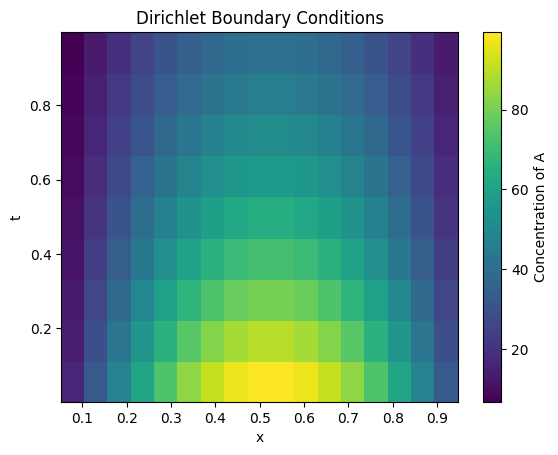

PyObject <matplotlib.text.Text object at 0x0000000029358588>

In [17]:
# Making heat map based off of calulated u
draw_heat_map(x, t, u)

In [18]:
# Making heat map based off of exact u to compare against calculated u heat map
Nₜ = length(t)
Nₓ = length(x)

u_e = zeros(Float64, Nₓ, Nₜ)
for i = 1:Nₓ 
    for j = 1:Nₜ
        u_e[i,j] = exact_u(x[i], t[j], D)
    end
end

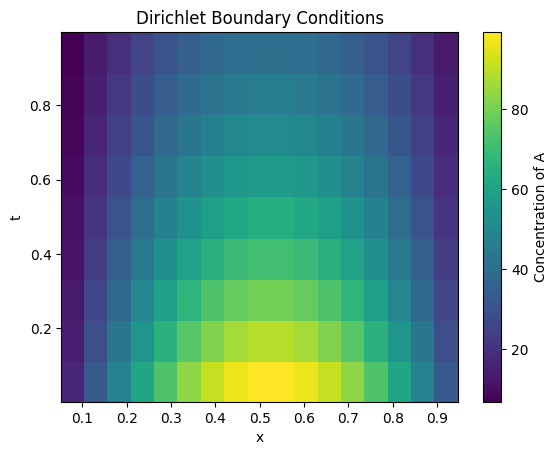

PyObject <matplotlib.text.Text object at 0x000000002D1E65C0>

In [19]:
draw_heat_map(x, t, u_e)

In [20]:
u

18×10 Array{Float64,2}:
 16.4144  14.7437  13.2009  11.8175  10.5784  …   7.58692   6.79117   6.07888
 32.381   29.0852  26.0416  23.3126  20.8683     14.9669   13.3971   11.9919 
 47.4644  42.6334  38.1721  34.1718  30.5889     21.9386   19.6376   17.5779 
 61.2531  55.0186  49.2613  44.0989  39.4751     28.3119   25.3424   22.6844 
 73.3709  65.9031  59.0067  52.8231  47.2846     33.9129   30.356    27.1721 
 83.4874  74.9899  67.1426  60.1065  53.8042  …  38.5889   34.5415   30.9186 
 91.3266  82.0312  73.4471  65.7502  58.8562     42.2122   37.7848   33.8217 
 96.6746  86.8348  77.7481  69.6005  62.3028     44.6841   39.9974   35.8023 
 99.3855  89.2699  79.9283  71.5523  64.0499     45.9372   41.1191   36.8063 
 99.3855  89.2699  79.9283  71.5523  64.0499     45.9372   41.1191   36.8063 
 96.6746  86.8348  77.7481  69.6005  62.3028  …  44.6841   39.9974   35.8023 
 91.3266  82.0312  73.4471  65.7502  58.8562     42.2122   37.7848   33.8217 
 83.4874  74.9899  67.1426  60.1065  53.

In [21]:
u_e

18×10 Array{Float64,2}:
 16.4139  14.7331  13.1878  11.8046  10.5665  …   7.57821   6.78337   6.07189
 32.3801  29.0643  26.0159  23.2872  20.8447     14.9497   13.3817   11.9782 
 47.4631  42.6028  38.1344  34.1346  30.5544     21.9134   19.615    17.5577 
 61.2514  54.9791  49.2126  44.0509  39.4306     28.2794   25.3133   22.6583 
 73.3689  65.8557  58.9484  52.7656  47.2313     33.874    30.3211   27.1408 
 83.4851  74.936   67.0763  60.041   53.7436  …  38.5445   34.5018   30.8831 
 91.324   81.9722  73.3745  65.6786  58.7899     42.1637   37.7414   33.7829 
 96.6719  86.7725  77.6713  69.5247  62.2326     44.6328   39.9515   35.7612 
 99.3828  89.2058  79.8494  71.4744  63.9778     45.8844   41.0718   36.764  
 99.3828  89.2058  79.8494  71.4744  63.9778     45.8844   41.0718   36.764  
 96.6719  86.7725  77.6713  69.5247  62.2326  …  44.6328   39.9515   35.7612 
 91.324   81.9722  73.3745  65.6786  58.7899     42.1637   37.7414   33.7829 
 83.4851  74.936   67.0763  60.041   53.

In [22]:
#Further shows the calculated u is correct
@assert(isapprox(u, u_e, rtol=.001), "Matrices are not equivalent.")